In [1]:
!pip uninstall numpy catboost -y
!pip install numpy --upgrade
!pip install catboost --upgrade


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached catboost-1.2.7-cp

# Model Development

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7bd85f169da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


## Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/NUS/IT5006/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/NUS/IT5006


In [4]:
# Replace with the path to Chicago dataset
chicago_filepath = "Chicago_after_FE.csv"
# Replace with the path to NIBRS test dataset
NIBRS_filepath = "NIBRS_after_FE.csv"

# Read the dataset
chicago_df = pd.read_csv(chicago_filepath)
NIBRS_df = pd.read_csv(NIBRS_filepath)

<ipython-input-4-db1789e0cf7f>:8: DtypeWarning: Columns (8,9,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  NIBRS_df = pd.read_csv(NIBRS_filepath)


In [5]:
# Check Date Range
c_min_date = chicago_df['date'].min()
c_max_date = chicago_df['date'].max()
n_min_date = NIBRS_df['date'].min()
n_max_date = NIBRS_df['date'].max()
print(f"Chicago Dataset Date Range: {c_min_date} to {c_max_date}")
print(f"NIBRS Dataset Date Range: {n_min_date} to {n_max_date}")

Chicago Dataset Date Range: 2020-07-31 17:29:00 to 2025-03-16 03:00:00
NIBRS Dataset Date Range: 2023-01-01 00:00:00 to 2023-12-31 23:00:00


In [6]:
chicago_df['date'] = pd.to_datetime(chicago_df['date'])
# Choose data from 2021-01-01 to 2022-12-31 for model training and initial testing
filtered_df = chicago_df[(chicago_df['date'] >= '2021-01-01') & (chicago_df['date'] <= '2022-12-31')]

print(f"Chicago Dataset Date Range After Filtering: {filtered_df['date'].min()}, {filtered_df['date'].max()}")

Chicago Dataset Date Range After Filtering: 2021-01-01 00:00:00, 2022-12-31 00:00:00


In [7]:
chicago_df = filtered_df
print("Chicago dataset shape:", chicago_df.shape)

Chicago dataset shape: (448489, 32)


In [8]:
NIBRS_df.shape

(562976, 37)

In [9]:
feature_columns = [
    'arrest', 'UNIFIED_LOCATION_CODE', 'month', 'day', 'hour', 'weekday',
    'is_weekend', 'is_holiday', 'crime_against', 'offense_category_name'
]

chicago_df = chicago_df[feature_columns]

In [10]:
# handle missing value
print(chicago_df.isnull().sum())
chicago_df = chicago_df.dropna()
print(chicago_df.isnull().sum())

arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64
arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


In [11]:
X = chicago_df.drop(columns=['arrest'])
y = chicago_df['arrest']

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [12]:
y_test.isna().sum()

0

In [13]:
report_dfs = {}
combined_report_df = pd.DataFrame()

## Model Training

## CatBoost Model:
- Handles categorical data well: CatBoost is great at working with categorical features **without needing much preprocessing**, which saves time and effort.
- Reduces overfitting: It has built-in tools to prevent overfitting, making predictions more reliable, especially with complex datasets like crime data.
- Strong performance: It often outperforms other models like decision trees or random forests, giving you accurate arrest predictions.

In [14]:
y_train.value_counts()

,count
arrest,
False,315072
True,43719


For `arrest` feature, it is extremely imbalanced with highly unarrested proportion.

`Catboost` can handle this with set `scale_pos_weight`  = # of False/ # of True.

In [15]:
arrest_weight = int(y_train.value_counts()[0] / y_train.value_counts()[1])
arrest_weight

<ipython-input-15-4050260de49a>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arrest_weight = int(y_train.value_counts()[0] / y_train.value_counts()[1])


7

In [16]:
# indicate categorical features
cat_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype == 'object']

# Initialize CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    scale_pos_weight=arrest_weight,  # improve the importance of Arrest=True
    early_stopping_rounds=50,
    eval_metric='F1',  # better evaluation metric for imbalanced data
    verbose=100,
    random_state=42
)
# Train the model
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), use_best_model=True)
# Predict
y_pred = model.predict(X_test)

# Evaluate the model
print("Chicago Classification Report:\n", classification_report(y_test, y_pred))


report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add to dictionary
report_dfs['Chicago - CatBoost'] = report_df

# Add model name as column for stacking
report_df['model'] = 'Chicago - CatBoost'
combined_report_df = pd.concat([combined_report_df, report_df])

0:	learn: 0.6910929	test: 0.6915118	best: 0.6915118 (0)	total: 419ms	remaining: 6m 58s
100:	learn: 0.7430253	test: 0.7411301	best: 0.7416014 (90)	total: 30.4s	remaining: 4m 30s
200:	learn: 0.7445414	test: 0.7417341	best: 0.7424794 (150)	total: 1m	remaining: 4m 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7424794168
bestIteration = 150

Shrink model to first 151 iterations.
Chicago Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.82      0.88     78768
        True       0.35      0.70      0.47     10930

    accuracy                           0.81     89698
   macro avg       0.65      0.76      0.67     89698
weighted avg       0.88      0.81      0.83     89698



### Optimize Parameters
TODO: with my local limited computational resources, it's hard to train :(

In [17]:
# param_dist = {
#     'depth': [4, 6],
#     'learning_rate': [0.03, 0.05],
#     'l2_leaf_reg': [3, 5, 7],
#     'scale_pos_weight': [arrest_weight, arrest_weight * 1.5],
#     'border_count': [32, 64]
# }

# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring='f1',
#     cv=2,
#     verbose=1,
#     n_jobs=-1  # Use all available cores
# )

# random_search.fit(X_train, y_train)

# print("Best Params:", random_search.best_params_)

### Test Model In NIBRS

In [18]:
NIBRS_df = NIBRS_df[feature_columns]
NIBRS_df.head()

,arrest,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name
0,True,1,1,19,21,3,0,0,Person,Assault Offenses
1,True,1,2,8,18,2,0,0,Property,Destruction/Damage/Vandalism of Property
2,True,1,4,13,13,3,0,0,Person,Assault Offenses
3,True,2,4,13,21,3,0,0,Society,Drug/Narcotic Offenses
4,True,1,5,20,15,5,1,0,Person,Assault Offenses


In [19]:
# handle missing value
print(chicago_df.isnull().sum())
chicago_df = chicago_df.dropna()
print(chicago_df.isnull().sum())

arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64
arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


In [20]:
X_NIBRS_test = NIBRS_df.drop(columns=['arrest'])
y_NIBRS_test = NIBRS_df['arrest']

In [21]:
# Keep the same columns sequences as in the training set
X_NIBRS_test = X_NIBRS_test[X_train.columns]

y_NIBRS_pred = model.predict(X_NIBRS_test)

print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))

report_dict = classification_report(y_NIBRS_test, y_NIBRS_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add to dictionary
report_dfs['NIBRS - CatBoost'] = report_df

# Add model name as column for stacking
report_df['model'] = 'NIBRS - CatBoost'
combined_report_df = pd.concat([combined_report_df, report_df])

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.79      0.84    467171
        True       0.35      0.55      0.43     95805

    accuracy                           0.75    562976
   macro avg       0.62      0.67      0.64    562976
weighted avg       0.80      0.75      0.77    562976



##Randomforest Model

In [22]:
# Check data types of all columns
print(chicago_df.dtypes)

# Check for non-numeric columns
non_numeric_columns = chicago_df.select_dtypes(exclude=['number']).columns
print(non_numeric_columns)

arrest                     bool
UNIFIED_LOCATION_CODE     int64
month                     int64
day                       int64
hour                      int64
weekday                   int64
is_weekend                int64
is_holiday                int64
crime_against            object
offense_category_name    object
dtype: object
Index(['arrest', 'crime_against', 'offense_category_name'], dtype='object')


In [23]:
label_encoder = LabelEncoder()
chicago_df['crime_against']= label_encoder.fit_transform(chicago_df['crime_against'])
chicago_df['offense_category_name']= label_encoder.fit_transform(chicago_df['offense_category_name'])

In [24]:
X = chicago_df.drop(columns=['arrest'])
y = chicago_df['arrest']

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
y_test.isna().sum()

0

* Random forests are great for handling imbalanced datasets.


* Set class_weight='balanced' to handle the imbalance by adjusting the weight of the classes in the tree.



In [26]:
# Handle class imbalance using SMOTE ONLY on the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [27]:
# Initialize and train your model
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_res, y_train_res)

# Predict and evaluate on the unmodified test set
y_pred = rf_model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add to dictionary
report_dfs['Chicago - RandomForest'] = report_df

# Add model name as column for stacking
report_df['model'] = 'Chicago - RandomForest'
combined_report_df = pd.concat([combined_report_df, report_df])

              precision    recall  f1-score   support

       False       0.93      0.87      0.90     78768
        True       0.37      0.55      0.44     10930

    accuracy                           0.83     89698
   macro avg       0.65      0.71      0.67     89698
weighted avg       0.86      0.83      0.84     89698

[[68493 10275]
 [ 4917  6013]]


#Test by NIBRS

In [28]:
NIBRS_df = NIBRS_df[feature_columns]
NIBRS_df.head()

,arrest,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name
0,True,1,1,19,21,3,0,0,Person,Assault Offenses
1,True,1,2,8,18,2,0,0,Property,Destruction/Damage/Vandalism of Property
2,True,1,4,13,13,3,0,0,Person,Assault Offenses
3,True,2,4,13,21,3,0,0,Society,Drug/Narcotic Offenses
4,True,1,5,20,15,5,1,0,Person,Assault Offenses


In [29]:
label_encoder = LabelEncoder()
NIBRS_df['crime_against']= label_encoder.fit_transform(NIBRS_df['crime_against'])
NIBRS_df['offense_category_name']= label_encoder.fit_transform(NIBRS_df['offense_category_name'])

In [30]:
X_NIBRS_test = NIBRS_df.drop(columns=['arrest'])
y_NIBRS_test = NIBRS_df['arrest']

In [31]:
# Keep the same columns sequences as in the training set
X_NIBRS_test = X_NIBRS_test[X_train.columns]

y_NIBRS_pred = rf_model.predict(X_NIBRS_test)

print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))
report_dict = classification_report(y_NIBRS_test, y_NIBRS_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add to dictionary
report_dfs['NIBRS - RandomForest'] = report_df

# Add model name as column for stacking
report_df['model'] = 'NIBRS - RandomForest'
combined_report_df = pd.concat([combined_report_df, report_df])

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.90      0.34      0.49    467171
        True       0.20      0.82      0.32     95805

    accuracy                           0.42    562976
   macro avg       0.55      0.58      0.41    562976
weighted avg       0.78      0.42      0.46    562976



##SGDClassifier

### Perceptron Classifier
The Perceptron, as a single-layer neural network, was selected for this arrest prediction task due to its distinct advantages in handling the given feature space (crime type, time, and location) and its fundamental algorithmic differences from the previously attempted CatBoost model.  

**Key Justifications:**  
1. **Linear Separability Prioritization**  
   - Given that arrest decisions may rely on threshold-based patterns (e.g., specific crime types or locations triggering higher arrest probabilities), the Perceptron’s linear decision boundary can efficiently capture such deterministic rules. Unlike tree-based models that partition feature space hierarchically, the Perceptron directly learns a hyperplane, potentially revealing simpler but legally actionable decision patterns.  

2. **Temporal Feature Efficiency**  
   - Time-based features (e.g., hour of day, day of week) often exhibit cyclical linear relationships with arrest rates (e.g., higher arrests during nighttime). The Perceptron’s weight-based learning mechanism can explicitly quantify these periodic trends through learned coefficients, whereas tree models may over-fragment temporal patterns.  

3. **Computational Scalability**  
   - For a dataset with spatially dense location data (e.g., latitude/longitude coordinates), the Perceptron’s O(*n*) training complexity outperforms ensemble methods when processing high-frequency updates. This aligns with real-world policing needs where rapid model retraining may be required.  

4. **Interpretability Trade-off**  
   - While less interpretable than decision trees, the Perceptron’s weights provide direct feature importance metrics (e.g., high-magnitude weights for violent crime types). This offers a middle ground between CatBoost’s complex feature interactions and purely linear models like logistic regression.  

## Imbalanced data
For `arrest` feature, it is extremely imbalanced with highly unarrested proportion.

For `Perception` model, we will use `SGDClassifier` with `log` loss function. The `log` loss function is used for binary classification problems and is suitable for our task of predicting arrests. The `SGDClassifier` is a linear classifier that uses stochastic gradient descent to optimize the model parameters. It is efficient for large datasets and can handle online learning scenarios.


In [32]:
# Define feature types
numeric_features = ['UNIFIED_LOCATION_CODE', 'month', 'day', 'hour', 'weekday']
binary_features = ['is_weekend', 'is_holiday']
categorical_features = ['crime_against', 'offense_category_name']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('binary', 'passthrough', binary_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Define the model pipeline
# Using SGDClassifier with log loss for binary classification
# SGDClassifier is a linear classifier that uses stochastic gradient descent
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(
        loss='log_loss',
        class_weight={False: 2, True: 8},
        penalty='l2',
        alpha=0.001,
        # class_weight='balanced',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    ))
])

# Split the data into features and target variable
X = chicago_df.drop(columns=['arrest'])
y = chicago_df['arrest']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

model.fit(X_train, y_train)


y_scores = model.decision_function(X_test)

# Optimal threshold calculation based on F1 score
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
# print("original performance\n", "Precision: ", precision, "Recall: ",recall,"thresholds: ", thresholds)

optimal_idx = np.argmax(2 * precision * recall / (precision + recall))  # F1 score
optimal_threshold = thresholds[optimal_idx]

# Optimal threshold
print("Optimal Threshold:", optimal_threshold)
y_pred_optimized = (y_scores > optimal_threshold).astype(int)


print("Classification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_optimized))

print("\nConfusion Matrix (Optimized Threshold):")
print(confusion_matrix(y_test, y_pred_optimized))

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add to dictionary
report_dfs['Chicago - SGDClassifier'] = report_df

# Add model name as column for stacking
report_df['model'] = 'Chicago - SGDClassifier'
combined_report_df = pd.concat([combined_report_df, report_df])

Optimal Threshold: 0.5464713330318056
Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

       False       0.93      0.97      0.95     78768
        True       0.68      0.46      0.55     10930

    accuracy                           0.91     89698
   macro avg       0.81      0.72      0.75     89698
weighted avg       0.90      0.91      0.90     89698


Confusion Matrix (Optimized Threshold):
[[76410  2358]
 [ 5864  5066]]


In [33]:
import joblib

# Save the trained model to a file
model_filename = "Model_Location.pkl"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

"""
Test the saved model with the NIBRS dataset (for merged testing)

# Load the model from the file
loaded_model = joblib.load(model_filename)
print("Model loaded from file.")
# Test the loaded model with the test set
y_pred_loaded = loaded_model.predict(X_test)
print("Loaded Model Classification Report:")
"""

Model saved to Model_Location.pkl


'\nTest the saved model with the NIBRS dataset (for merged testing)\n\n# Load the model from the file\nloaded_model = joblib.load(model_filename)\nprint("Model loaded from file.")\n# Test the loaded model with the test set\ny_pred_loaded = loaded_model.predict(X_test)\nprint("Loaded Model Classification Report:")\n'

### Optimize Parameters
TODO: with my local limited computational resources, it's hard to train :(

In [34]:
# param_dist = {
#     'depth': [4, 6],
#     'learning_rate': [0.03, 0.05],
#     'l2_leaf_reg': [3, 5, 7],
#     'scale_pos_weight': [arrest_weight, arrest_weight * 1.5],
#     'border_count': [32, 64]
# }

# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring='f1',
#     cv=2,
#     verbose=1,
#     n_jobs=-1  # Use all available cores
# )

# random_search.fit(X_train, y_train)

# print("Best Params:", random_search.best_params_)

## Test Model In NIBRS

In [35]:
NIBRS_df = NIBRS_df[feature_columns]
NIBRS_df.head()

,arrest,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name
0,True,1,1,19,21,3,0,0,0,2
1,True,1,2,8,18,2,0,0,1,6
2,True,1,4,13,13,3,0,0,0,2
3,True,2,4,13,21,3,0,0,2,7
4,True,1,5,20,15,5,1,0,0,2


In [36]:
# handle missing value
print(chicago_df.isnull().sum())
chicago_df = chicago_df.dropna()
print(chicago_df.isnull().sum())

arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64
arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


In [37]:
X_NIBRS_test = NIBRS_df.drop(columns=['arrest'])
y_NIBRS_test = NIBRS_df['arrest']

In [38]:
# Keep the same columns sequences as in the training set
X_NIBRS_test = X_NIBRS_test[X_train.columns]

y_NIBRS_pred = model.predict(X_NIBRS_test)

print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))

report_dict = classification_report(y_NIBRS_test, y_NIBRS_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add to dictionary
report_dfs['NIBRS - SGDClassifier'] = report_df

# Add model name as column for stacking
report_df['model'] = 'NIBRS - SGDClassifier'
combined_report_df = pd.concat([combined_report_df, report_df])

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.33      0.48    467171
        True       0.19      0.76      0.30     95805

    accuracy                           0.40    562976
   macro avg       0.53      0.54      0.39    562976
weighted avg       0.75      0.40      0.45    562976



# Model Evaluation

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

## Standard Classification Metrics

In [70]:
# Display the DataFrame
combined_report_df

,precision,recall,f1-score,support,model
False,0.951644,0.820498,0.881218,78768.000000,Chicago - CatBoost
True,0.350975,0.699543,0.467431,10930.000000,Chicago - CatBoost
accuracy,0.805759,0.805759,0.805759,0.805759,Chicago - CatBoost
macro avg,0.651310,0.760020,0.674325,89698.000000,Chicago - CatBoost
weighted avg,0.878451,0.805759,0.830797,89698.000000,Chicago - CatBoost
False,0.896126,0.791903,0.840797,467171.000000,NIBRS - CatBoost
True,0.352487,0.552393,0.430358,95805.000000,NIBRS - CatBoost
accuracy,0.751144,0.751144,0.751144,0.751144,NIBRS - CatBoost
macro avg,0.624306,0.672148,0.635578,562976.000000,NIBRS - CatBoost
weighted avg,0.803612,0.751144,0.770950,562976.000000,NIBRS - CatBoost


In [41]:
print("Chicago Classification Report:\n", classification_report(y_test, y_pred))
print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))

Chicago Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.87      0.90     78768
        True       0.37      0.55      0.44     10930

    accuracy                           0.83     89698
   macro avg       0.65      0.71      0.67     89698
weighted avg       0.86      0.83      0.84     89698

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.33      0.48    467171
        True       0.19      0.76      0.30     95805

    accuracy                           0.40    562976
   macro avg       0.53      0.54      0.39    562976
weighted avg       0.75      0.40      0.45    562976



In [42]:
# calculate ROC AUC score
# for Chicago test set
y_proba = model.predict_proba(X_test)[:, 1]
c_auc_score = roc_auc_score(y_test, y_proba)
print("Chicago ROC-AUC Score:", c_auc_score)

# for NIBRS test set
y_NIBRS_proba = model.predict_proba(X_NIBRS_test)[:, 1]
n_auc_score = roc_auc_score(y_NIBRS_test, y_NIBRS_proba)
print("NIBRS ROC-AUC Score:", n_auc_score)

Chicago ROC-AUC Score: 0.8204449674344465
NIBRS ROC-AUC Score: 0.6497355109204433


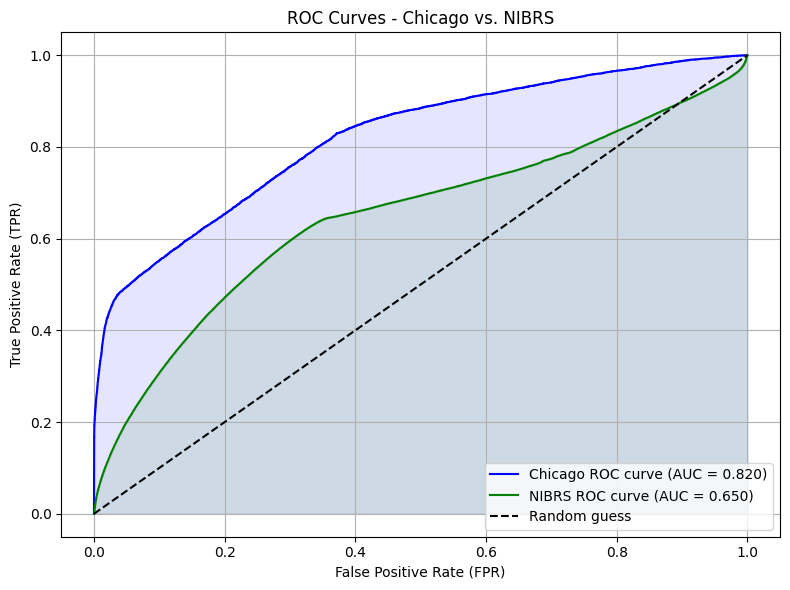

In [43]:
# Plot ROC Curves
fpr_c, tpr_c, _ = roc_curve(y_test, y_proba)
auc_c = roc_auc_score(y_test, y_proba)
fpr_n, tpr_n, _ = roc_curve(y_NIBRS_test, y_NIBRS_proba)
auc_n = roc_auc_score(y_NIBRS_test, y_NIBRS_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_c, tpr_c, label=f'Chicago ROC curve (AUC = {auc_c:.3f})', color='blue')
plt.plot(fpr_n, tpr_n, label=f'NIBRS ROC curve (AUC = {auc_n:.3f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.fill_between(fpr_c, tpr_c, alpha=0.1, color='blue')
plt.fill_between(fpr_n, tpr_n, alpha=0.1, color='green')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves - Chicago vs. NIBRS')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Temporal Accuracy Measures

In [44]:
def concat_eval_df(X_test, y_test, y_pred):
    eval_df = X_test.reset_index(drop=True).copy()

    eval_df['y_true'] = pd.Series(y_test).reset_index(drop=True)
    eval_df['y_pred'] = pd.Series(y_pred).reset_index(drop=True)

    return eval_df

In [45]:
# Create evaluation DataFrame for Chicago test set
eval_df_chicago = concat_eval_df(X_test, y_test, y_pred)

# Create evaluation DataFrame for NIBRS test set
eval_df_NIBRS = concat_eval_df(X_NIBRS_test, y_NIBRS_test, y_NIBRS_pred)

In [46]:
eval_df_chicago.head()

,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name,y_true,y_pred
0,10,9,18,10,5,1,0,1,1,False,False
1,1,4,30,22,5,1,0,1,1,False,True
2,2,6,12,8,6,1,0,2,13,False,False
3,2,6,17,11,4,0,0,1,1,False,False
4,1,5,28,0,5,1,0,1,1,False,True


In [47]:
eval_df_NIBRS.head()

,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name,y_true,y_pred
0,1,1,19,21,3,0,0,0,2,True,True
1,1,2,8,18,2,0,0,1,6,True,True
2,1,4,13,13,3,0,0,0,2,True,True
3,2,4,13,21,3,0,0,2,7,True,True
4,1,5,20,15,5,1,0,0,2,True,True


In [48]:
def evaluate_temporal_performance(df, group_col, y_true_col='y_true', y_pred_col='y_pred'):
    grouped_perf = df.groupby(group_col).apply(
        lambda g: pd.Series({
            'accuracy': accuracy_score(g[y_true_col], g[y_pred_col]),
            'f1_score': f1_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'precision': precision_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'recall': recall_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'count': len(g)
        })
    ).reset_index()

    return grouped_perf

In [49]:
# Note: df1 is for Chicago, df2 is for NIBRS
def plot_temporal_comparison(df1, df2, x_col, dataset_names=('Chicago', 'NIBRS'), title_prefix=''):

    metrics = ['accuracy', 'f1_score', 'precision', 'recall']
    titles = ['Accuracy', 'F1 Score', 'Precision', 'Recall']

    df1 = df1.sort_values(by=x_col)
    df2 = df2.sort_values(by=x_col)
    x_vals = df1[x_col]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        ax = axs[row][col]

        ax.plot(x_vals, df1[metric], marker='o', label=dataset_names[0], color='blue')
        ax.plot(x_vals, df2[metric], marker='s', label=dataset_names[1], color='green', linestyle='--')

        ax.set_title(f'{titles[i]} by {x_col.capitalize()}', fontsize=12)
        ax.set_xlabel(x_col.capitalize())
        ax.set_ylabel(titles[i])
        ax.set_xticks(sorted(x_vals.unique()))
        ax.grid(True)
        ax.legend()

    plt.suptitle(f'{title_prefix} Performance Comparison: {dataset_names[0]} vs {dataset_names[1]}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [50]:
def plot_binary_group_bars_split(df1, df2, group_col='is_weekend', dataset_names=('Chicago', 'NIBRS'), title_prefix=''):
    metrics = ['accuracy', 'f1_score', 'precision', 'recall']
    df1 = df1.sort_values(by=group_col)
    df2 = df2.sort_values(by=group_col)

    categories = sorted(df1[group_col].unique())  # e.g. [0, 1]
    bar_width = 0.2
    x = np.arange(len(categories))
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=False)

    for i, metric in enumerate(metrics):
        ax = axs[i]

        df1_scores = df1.set_index(group_col)[metric].loc[categories]
        df2_scores = df2.set_index(group_col)[metric].loc[categories]

        ax.bar(x - bar_width/2, df1_scores, width=bar_width, label=dataset_names[0], color='blue')
        ax.bar(x + bar_width/2, df2_scores, width=bar_width, label=dataset_names[1], color='green', hatch='//')

        ax.set_title(metric.title(), fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels([f'{group_col}={c}' for c in categories])
        ax.set_ylim(0, 1)
        ax.set_ylabel("Score")
        ax.grid(axis='y')
        if i == 0:
            ax.legend()

    plt.suptitle(f'{title_prefix} Performance by {group_col}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

### Evaluate Performance in Hour

In [51]:
# Evaluate performance in Hour for Chicago test set
hourly_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='hour')
print("Performance in Hour for Chicago test set: \n", hourly_perf_chicago)
# Evaluate performance in Hour for NIBRS test set
hourly_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='hour')
print("Performance in Hour for NIBRS test set: \n", hourly_perf_NIBRS)

<ipython-input-48-bb9b9a0aee42>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_perf = df.groupby(group_col).apply(


Performance in Hour for Chicago test set: 
     hour  accuracy  f1_score  precision    recall   count
0      0  0.834037  0.361635   0.281633  0.505124  7339.0
1      1  0.776325  0.347390   0.276358  0.467568  2906.0
2      2  0.807374  0.320955   0.271300  0.392857  2658.0
3      3  0.826424  0.271511   0.210059  0.383784  2195.0
4      4  0.842767  0.229692   0.200000  0.269737  1749.0
5      5  0.864776  0.280702   0.250000  0.320000  1516.0
6      6  0.870536  0.292683   0.248521  0.355932  1568.0
7      7  0.842351  0.318548   0.265101  0.398990  2144.0
8      8  0.834932  0.296192   0.243619  0.377698  3023.0
9      9  0.864879  0.426696   0.368620  0.506494  3878.0
10    10  0.844867  0.516588   0.443691  0.618147  3945.0
11    11  0.824297  0.553606   0.472284  0.668760  3910.0
12    12  0.857634  0.484429   0.412250  0.587248  5233.0
13    13  0.843202  0.495427   0.425393  0.593066  4222.0
14    14  0.845326  0.468365   0.398045  0.568862  4183.0
15    15  0.834321  0.397229

<ipython-input-48-bb9b9a0aee42>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_perf = df.groupby(group_col).apply(


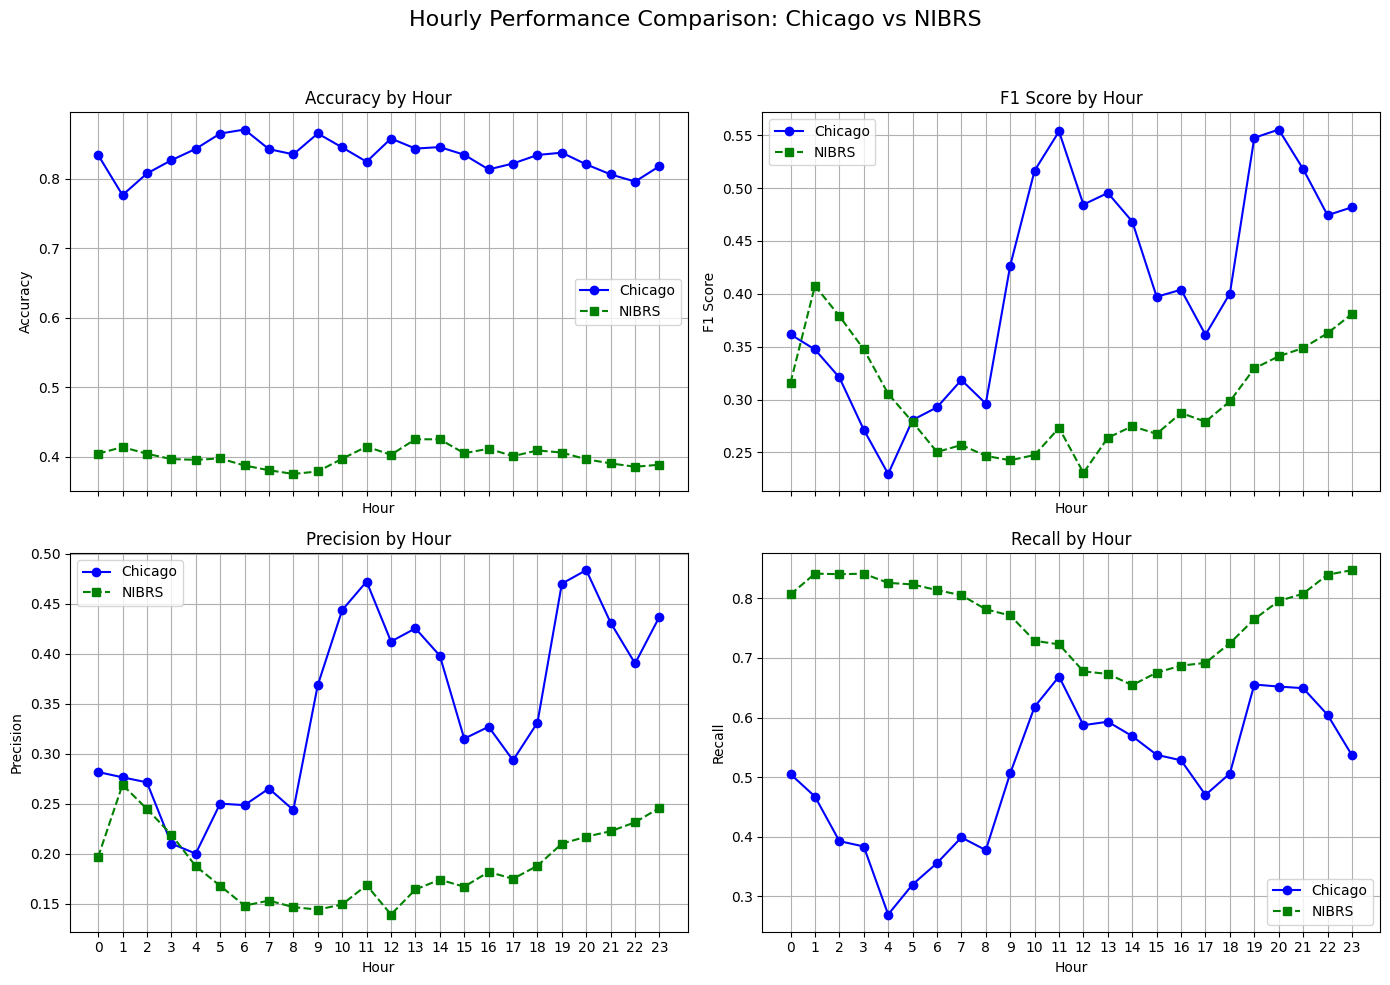

In [52]:
hourly_perf_chicago = hourly_perf_chicago.sort_values(by='hour')
hourly_perf_NIBRS = hourly_perf_NIBRS.sort_values(by='hour')

hours = hourly_perf_chicago['hour']

plot_temporal_comparison(
    hourly_perf_chicago,
    hourly_perf_NIBRS,
    x_col='hour',
    dataset_names=('Chicago', 'NIBRS'),
    title_prefix='Hourly'
)

### Evaluate Performance in Month

In [53]:
# Evaluate performance in Month for Chicago test set
monthly_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='month')
print("Performance in Month for Chicago test set: \n", monthly_perf_chicago)
# Evaluate performance in Month for NIBRS test set
monthly_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='month')
print("Performance in Month for NIBRS test set: \n", monthly_perf_NIBRS)

<ipython-input-48-bb9b9a0aee42>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_perf = df.groupby(group_col).apply(


Performance in Month for Chicago test set: 
     month  accuracy  f1_score  precision    recall   count
0       1  0.823844  0.438315   0.365997  0.546250  6358.0
1       2  0.801032  0.499552   0.417352  0.622074  5619.0
2       3  0.832367  0.512842   0.457551  0.583333  6902.0
3       4  0.818614  0.476844   0.390999  0.610989  6726.0
4       5  0.803837  0.451660   0.378825  0.559169  7662.0
5       6  0.826311  0.449742   0.363987  0.588358  7974.0
6       7  0.837851  0.428323   0.358285  0.532397  8116.0
7       8  0.839634  0.408526   0.336996  0.518602  8306.0
8       9  0.833511  0.402553   0.328017  0.520925  8433.0
9      10  0.851960  0.414174   0.350467  0.506187  8599.0
10     11  0.838368  0.407767   0.335196  0.520446  7548.0
11     12  0.846546  0.394068   0.339726  0.469105  7455.0
Performance in Month for NIBRS test set: 
     month  accuracy  f1_score  precision    recall    count
0       1  0.394674  0.298157   0.185410  0.760779  45288.0
1       2  0.393567  0.30

<ipython-input-48-bb9b9a0aee42>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_perf = df.groupby(group_col).apply(


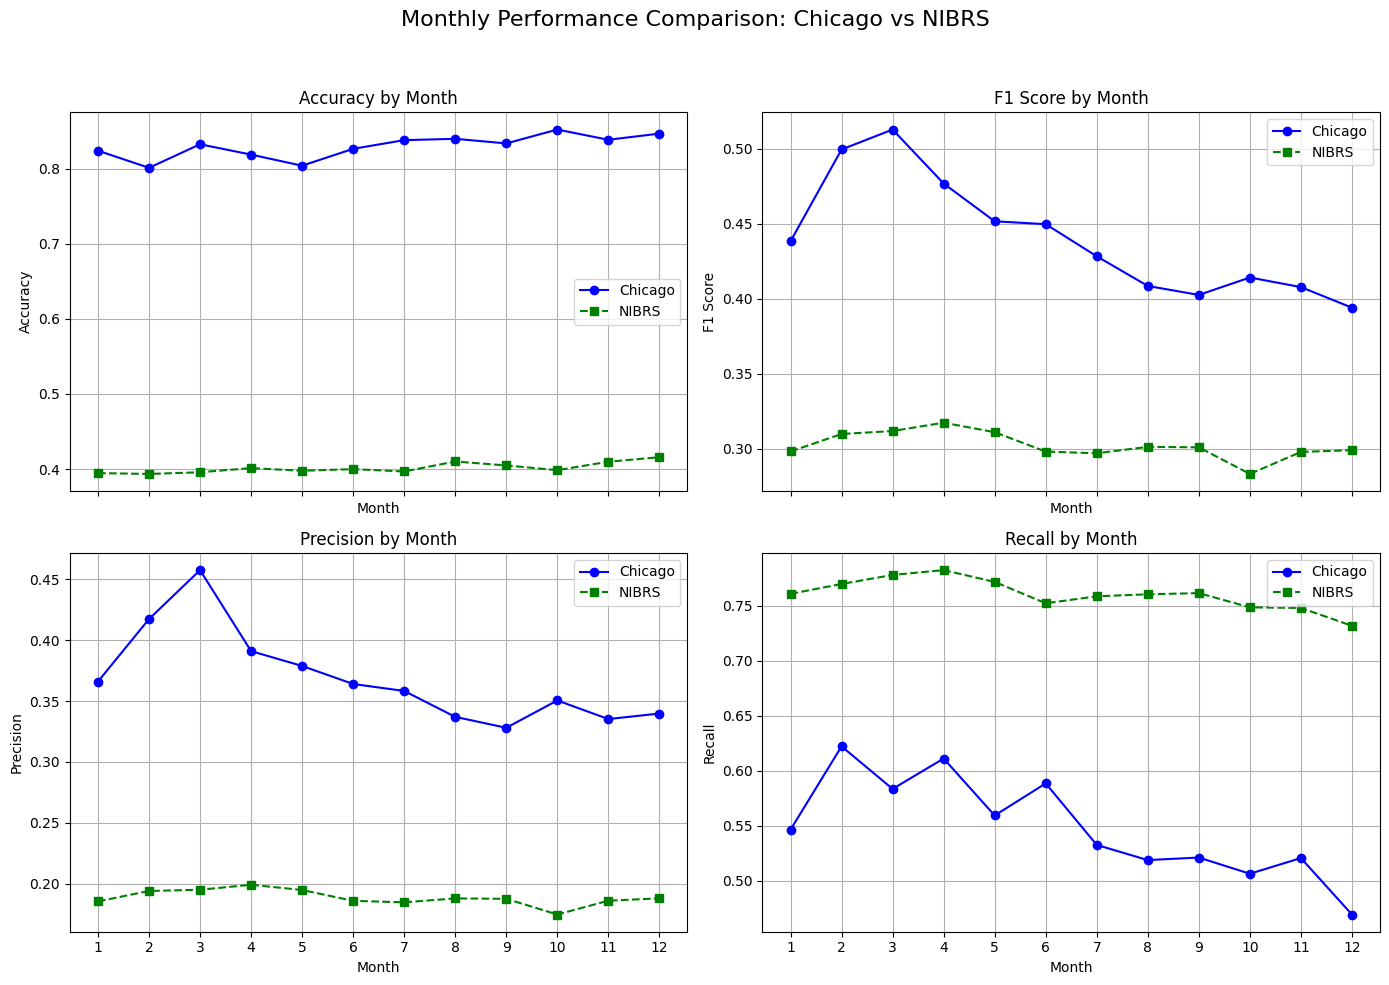

In [54]:
monthly_perf_chicago = monthly_perf_chicago.sort_values(by='month')
monthly_perf_NIBRS = monthly_perf_NIBRS.sort_values(by='month')

months = monthly_perf_chicago['month']

plot_temporal_comparison(
    monthly_perf_chicago,
    monthly_perf_NIBRS,
    x_col='month',
    dataset_names=('Chicago', 'NIBRS'),
    title_prefix='Monthly'
)

### Evaluate Performance in Weekend

In [55]:
# Evaluate performance in Month for Chicago test set
weekend_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='is_weekend')
print("Performance in is_weekend for Chicago test set: \n", weekend_perf_chicago)
# Evaluate performance in Month for NIBRS test set
weekend_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='is_weekend')
print("Performance in is_weekend for NIBRS test set: \n", weekend_perf_NIBRS)

<ipython-input-48-bb9b9a0aee42>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_perf = df.groupby(group_col).apply(


Performance in is_weekend for Chicago test set: 
    is_weekend  accuracy  f1_score  precision    recall    count
0           0  0.832378  0.446232   0.370092  0.561818  64055.0
1           1  0.826268  0.430962   0.366819  0.522291  25643.0
Performance in is_weekend for NIBRS test set: 
    is_weekend  accuracy  f1_score  precision    recall     count
0           0  0.404729  0.293453   0.182308  0.751787  402457.0
1           1  0.394090  0.321965   0.202889  0.779398  160519.0


<ipython-input-48-bb9b9a0aee42>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_perf = df.groupby(group_col).apply(


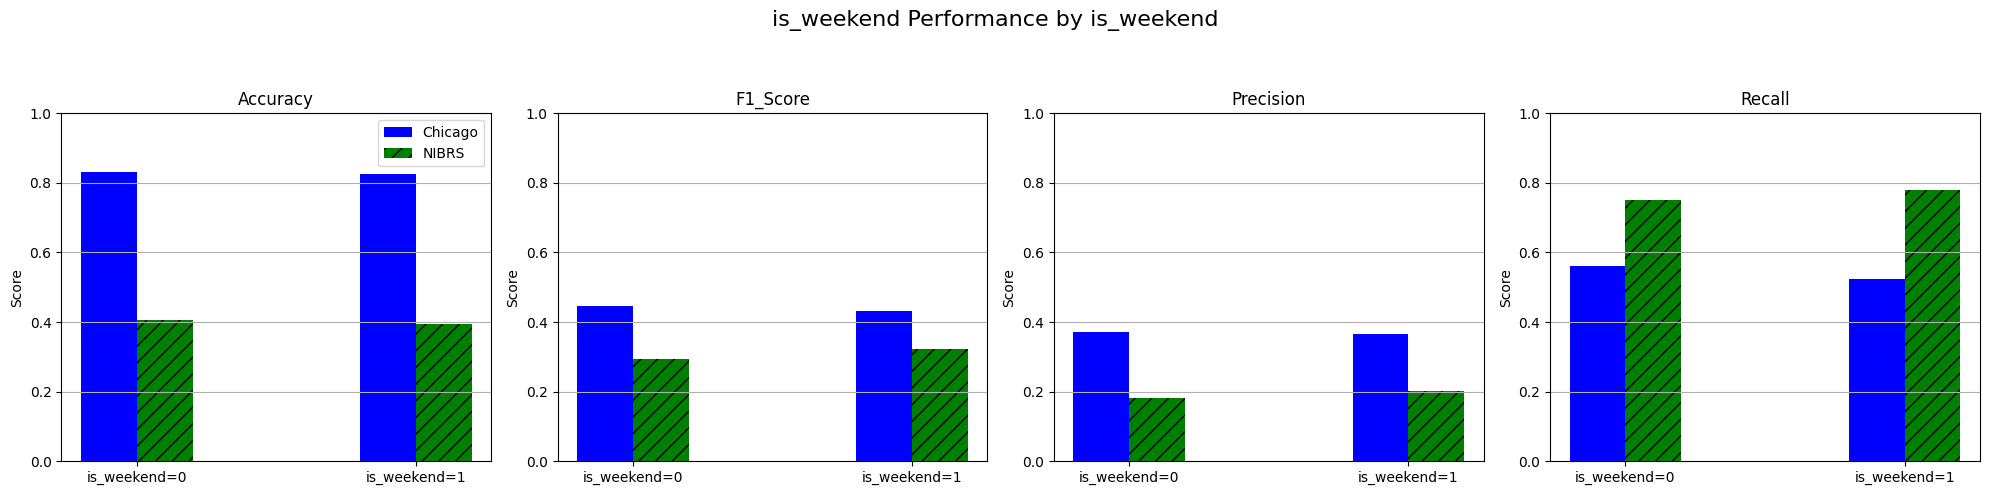

In [56]:
weekend_perf_chicago = weekend_perf_chicago.sort_values(by='is_weekend')
weekend_perf_NIBRS = weekend_perf_NIBRS.sort_values(by='is_weekend')

plot_binary_group_bars_split(
    weekend_perf_chicago,
    weekend_perf_NIBRS,
    group_col='is_weekend',
    dataset_names=('Chicago', 'NIBRS'),
    title_prefix='is_weekend'
)

### Evaluate performance in is_holiday

In [57]:
# Evaluate performance in Holiday for Chicago test set
holiday_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='is_holiday')
print("Performance in is_holiday for Chicago test set: \n", holiday_perf_chicago)
# Evaluate performance in Holiday for NIBRS test set
holiday_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='is_holiday')
print("Performance in is_holiday for NIBRS test set: \n", holiday_perf_NIBRS)

<ipython-input-48-bb9b9a0aee42>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_perf = df.groupby(group_col).apply(


Performance in is_holiday for Chicago test set: 
    is_holiday  accuracy  f1_score  precision    recall    count
0           0  0.830109  0.439992   0.366544  0.550253  86214.0
1           1  0.843571  0.487300   0.438983  0.547569   3484.0
Performance in is_holiday for NIBRS test set: 
    is_holiday  accuracy  f1_score  precision    recall     count
0           0  0.402396  0.301830   0.188356  0.759221  543510.0
1           1  0.382153  0.304597   0.188614  0.790991   19466.0


<ipython-input-48-bb9b9a0aee42>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_perf = df.groupby(group_col).apply(


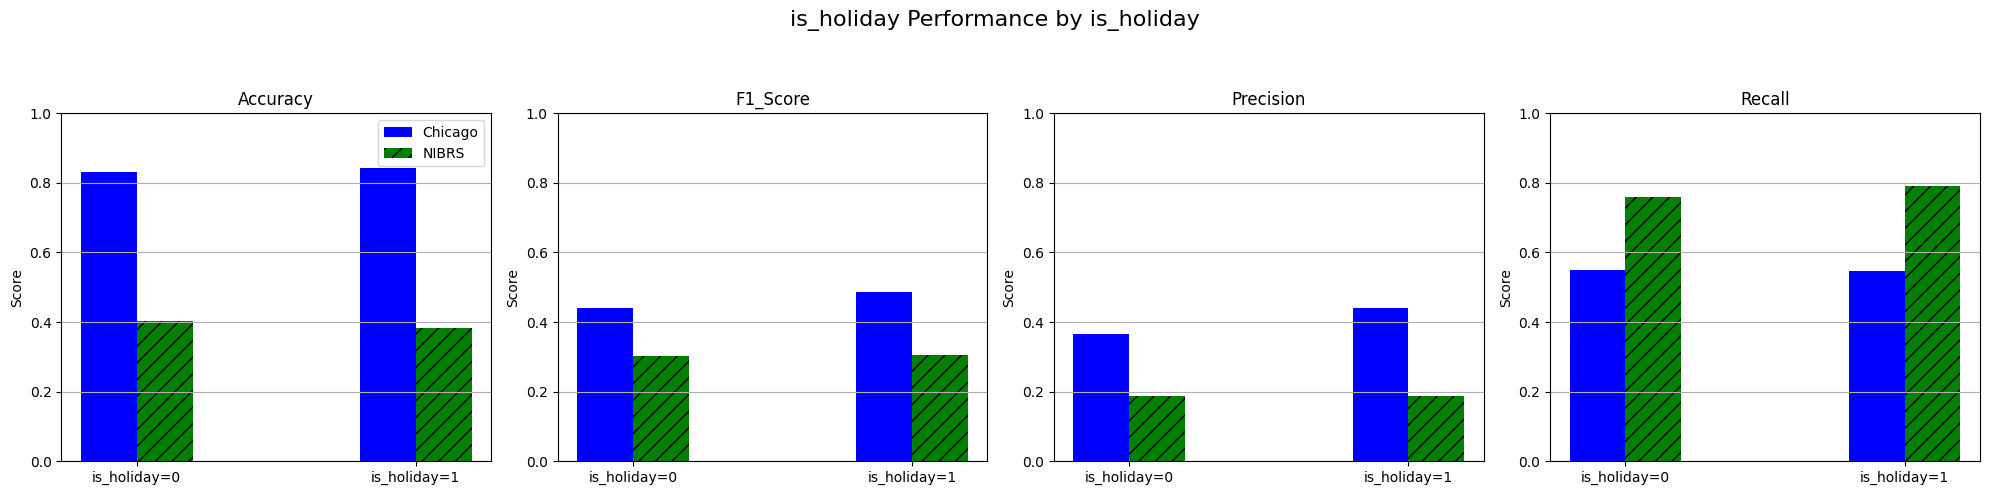

In [58]:
holiday_perf_chicago = holiday_perf_chicago.sort_values(by='is_holiday')
holiday_perf_NIBRS = holiday_perf_NIBRS.sort_values(by='is_holiday')

plot_binary_group_bars_split(
    holiday_perf_chicago,
    holiday_perf_NIBRS,
    group_col='is_holiday',
    dataset_names=('Chicago', 'NIBRS'),
    title_prefix='is_holiday'
)

## Spatial Accuracy Evaluation

In [59]:
unified_location_mapping = {
    "Residence": 1,
    "Street/Outdoor": 2,
    "Transportation Hub": 3,
    "Retail/Commercial": 4,
    "Entertainment": 5,
    "Government/Public": 6,
    "Medical Facility": 7,
    "Workplace/Office": 8,
    "Parking Lot": 9,
    "Unknown/Other": 10
}
reverse_location_mapping = {v: k for k, v in unified_location_mapping.items()}

In [60]:
eval_df_chicago['location_name'] = eval_df_chicago['UNIFIED_LOCATION_CODE'].map(reverse_location_mapping)
eval_df_NIBRS['location_name'] = eval_df_NIBRS['UNIFIED_LOCATION_CODE'].map(reverse_location_mapping)

In [61]:
def evaluate_spatial_performance(df, group_col='location_name', y_true_col='y_true', y_pred_col='y_pred'):
    grouped_perf = df.groupby(group_col).apply(
        lambda g: pd.Series({
            'accuracy': accuracy_score(g[y_true_col], g[y_pred_col]),
            'f1_score': f1_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'precision': precision_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'recall': recall_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'count': len(g)
        })
    ).reset_index().sort_values(by='f1_score', ascending=False)

    return grouped_perf

In [62]:
def plot_spatial_performance_comparison(df1, df2, metric='f1_score', dataset_names=('Chicago', 'NIBRS')):

    merged = df1[['location_name', metric]].merge(
        df2[['location_name', metric]],
        on='location_name',
        suffixes=(f'_{dataset_names[0]}', f'_{dataset_names[1]}')
    )

    locations = merged['location_name']
    vals1 = merged[f'{metric}_{dataset_names[0]}']
    vals2 = merged[f'{metric}_{dataset_names[1]}']

    x = np.arange(len(locations))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(x - width/2, vals1, height=width, label=dataset_names[0], color='blue')
    ax.barh(x + width/2, vals2, height=width, label=dataset_names[1], color='green')

    ax.set_yticks(x)
    ax.set_yticklabels(locations)
    ax.invert_yaxis()
    ax.set_xlabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} by Location ({dataset_names[0]} vs {dataset_names[1]})')
    ax.legend()
    ax.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [63]:
chicago_spatial_perf = evaluate_spatial_performance(eval_df_chicago)
print("Spatial Performance for Chicago test set: \n", chicago_spatial_perf)
NIBRS_spatial_perf = evaluate_spatial_performance(eval_df_NIBRS)
print("Spatial Performance for NIBRS test set: \n", NIBRS_spatial_perf)

<ipython-input-61-c36571819c5e>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_perf = df.groupby(group_col).apply(


Spatial Performance for Chicago test set: 
         location_name  accuracy  f1_score  precision    recall    count
1   Government/Public  0.905660  0.862385   0.903846  0.824561    159.0
6      Street/Outdoor  0.847628  0.603509   0.529875  0.700910  31889.0
2    Medical Facility  0.843511  0.528736   0.560976  0.500000    524.0
3         Parking Lot  0.902610  0.504854   0.417112  0.639344   3142.0
0       Entertainment  0.830343  0.434783   0.430108  0.439560    613.0
7  Transportation Hub  0.775076  0.403226   0.345622  0.483871    987.0
8       Unknown/Other  0.834304  0.327112   0.268376  0.418761  29373.0
9    Workplace/Office  0.896808  0.294416   0.261261  0.337209   1347.0
5   Retail/Commercial  0.717668  0.292237   0.255591  0.341151   2745.0
4           Residence  0.797928  0.232483   0.173042  0.354128  18919.0
Spatial Performance for NIBRS test set: 
         location_name  accuracy  f1_score  precision    recall     count
7  Transportation Hub  0.560946  0.464809   0.315

<ipython-input-61-c36571819c5e>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_perf = df.groupby(group_col).apply(


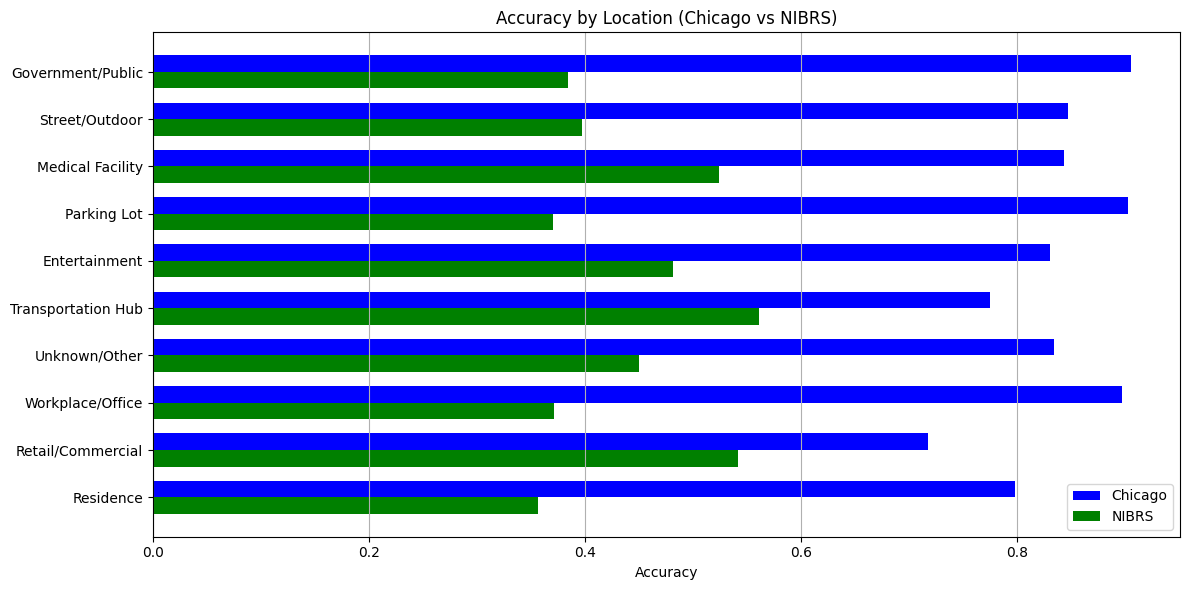

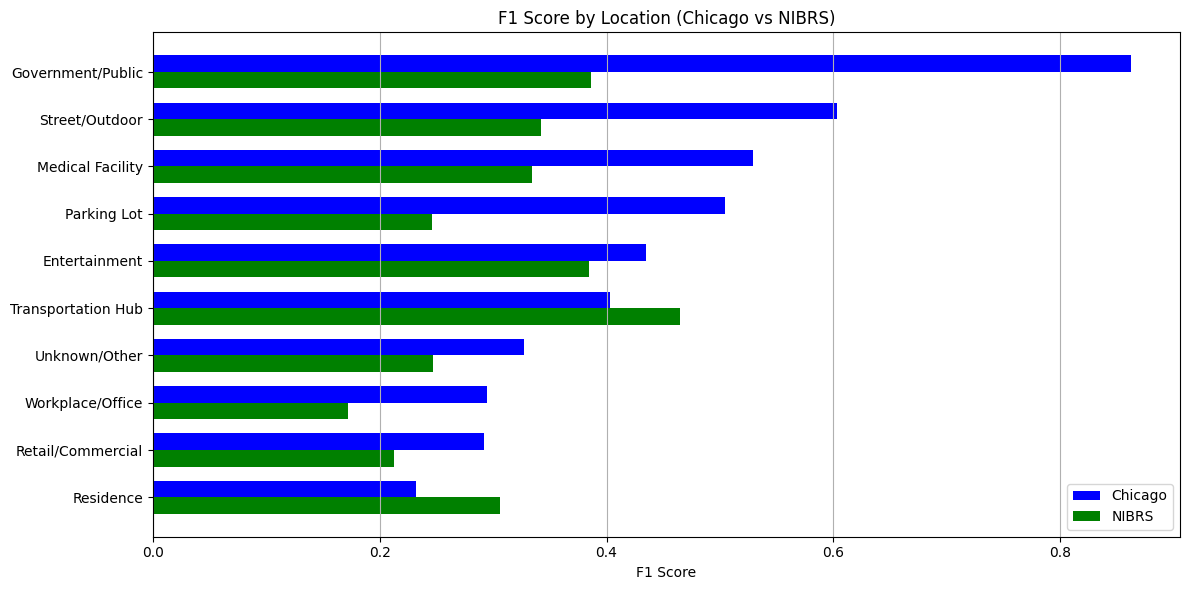

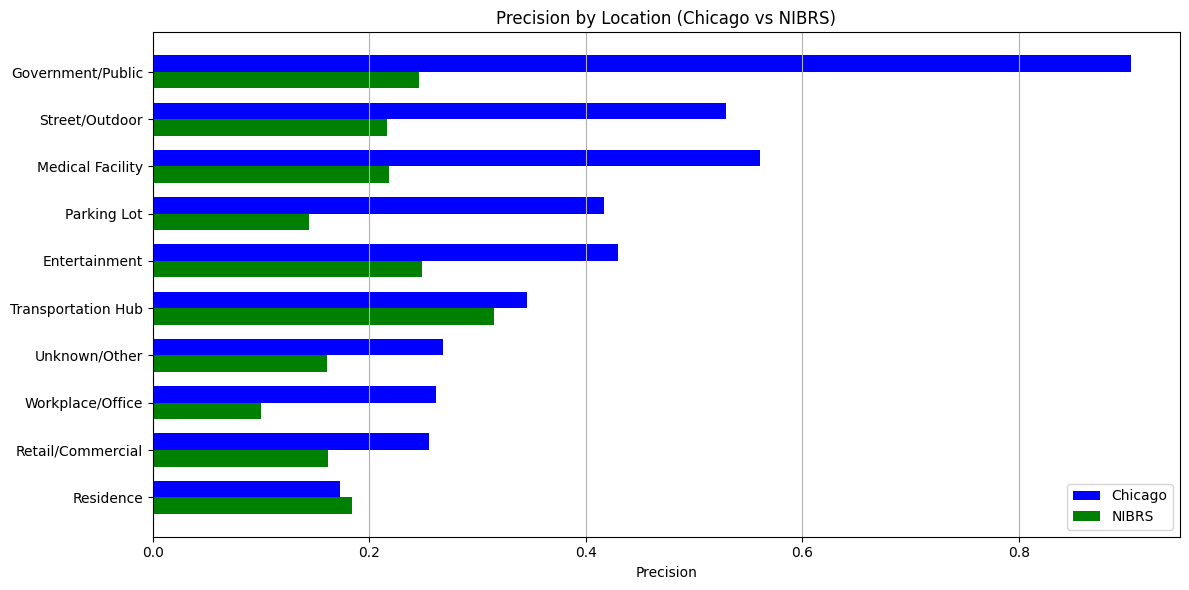

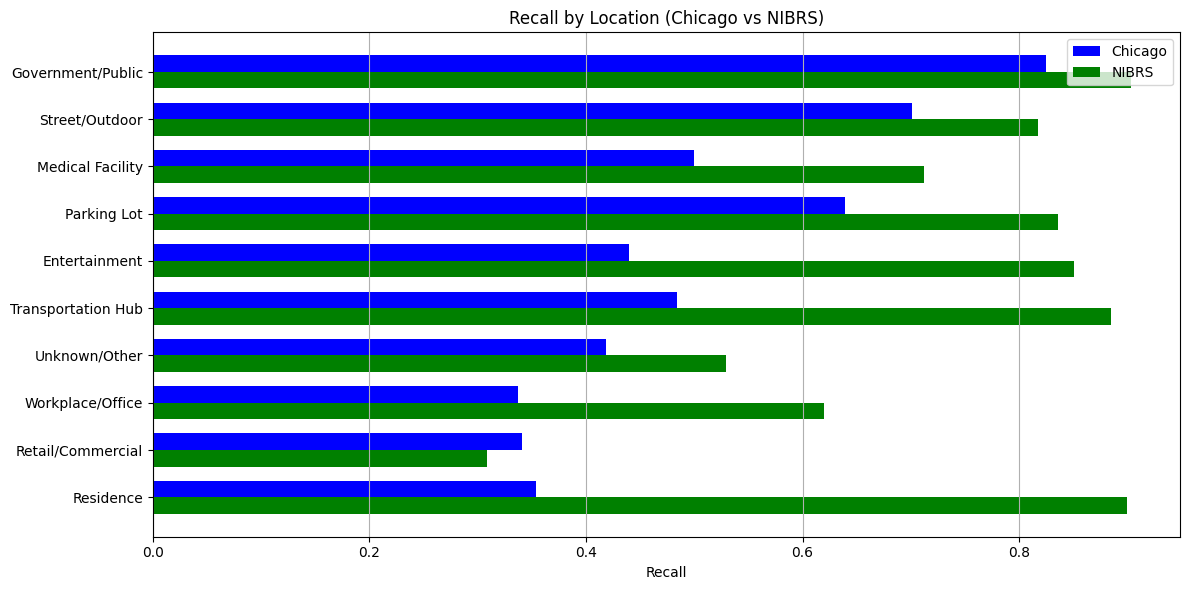

In [64]:
metrics = ['accuracy', 'f1_score', 'precision', 'recall']

for metric in metrics:
    plot_spatial_performance_comparison(
        chicago_spatial_perf,
        NIBRS_spatial_perf,
        metric=metric,
        dataset_names=('Chicago', 'NIBRS')
    )
# plot_spatial_performance_bar(spatial_perf, metric='accuracy')